# Import packages needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
%matplotlib inline

# Read in data and merge climbing record with weather

Contains 2 years of climbing logs, it's stated that weather data is missing for some dates

In [2]:
climbing_statistics = pd.read_csv('data/climbing_statistics.csv')
climbing_statistics['Date'] = pd.to_datetime(climbing_statistics['Date'], format='%m/%d/%Y')
weather = pd.read_csv('data/Rainier_Weather.csv')
weather['Date'] = pd.to_datetime(weather['Date'], format='%m/%d/%Y')

climbs_df = pd.merge(climbing_statistics, weather, how='left', on='Date')

### Look at the data

In [3]:
display(climbs_df.head())

,Date,Route,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,2015-11-27,Disappointment Cleaver,2,0,0.0,13.643750,26.321667,19.715000,27.839583,68.004167,88.496250
1,2015-11-21,Disappointment Cleaver,3,0,0.0,13.749583,31.300000,21.690708,2.245833,117.549667,93.660417
2,2015-10-15,Disappointment Cleaver,2,0,0.0,13.461250,46.447917,27.211250,17.163625,259.121375,138.387000
3,2015-10-13,Little Tahoma,8,0,0.0,13.532083,40.979583,28.335708,19.591167,279.779167,176.382667
4,2015-10-09,Disappointment Cleaver,2,0,0.0,13.216250,38.260417,74.329167,65.138333,264.687500,27.791292


Only one column (Route) that is categorial

### Number of observations and missing data points

In [4]:
climbs_df.isnull().agg(['count', 'sum', 'mean'])

,Date,Route,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
count,4077.0,4077.0,4077.0,4077.0,4077.0,4077.000000,4077.000000,4077.000000,4077.000000,4077.000000,4077.000000
sum,0.0,0.0,0.0,0.0,0.0,2182.000000,2182.000000,2182.000000,2182.000000,2182.000000,2182.000000
mean,0.0,0.0,0.0,0.0,0.0,0.535197,0.535197,0.535197,0.535197,0.535197,0.535197


Note that missing values are only present for weather data

### Inspect numeric values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002537E10B688>,
      dtype=object)

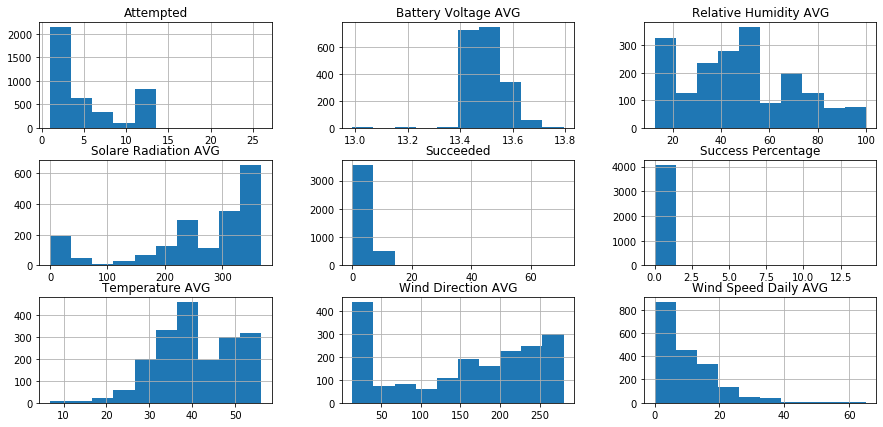

In [5]:
climbs_df.hist(figsize=[15,7])

### Inspect categorical value

Disappointment Cleaver              2728
Emmons-Winthrop                      632
Kautz Glacier                        182
Gibralter Ledges                      76
Little Tahoma                         70
Liberty RIngraham Directge            69
glacier only - no summit attempt      66
Fuhrer's Finger                       65
Ingraham Direct                       53
Unknown                               32
Fuhrers Finger                        27
Ptarmigan RIngraham Directge          22
Kautz Cleaver                         14
Tahoma Glacier                        11
Success Cleaver                        6
Gibralter Chute                        5
Mowich Face                            4
Sunset RIngraham Directge              3
Edmonds HW                             2
Nisqually Glacier                      2
Curtis RIngraham Directge              2
Wilson Headwall                        2
Sunset Amphitheater                    1
Tahoma Cleaver                         1
Liberty Wall    

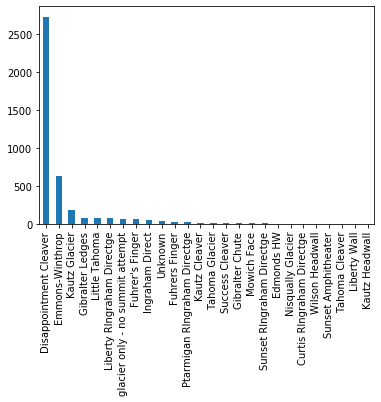

In [6]:
print(climbs_df.Route.value_counts())
climbs_df.Route.value_counts().plot.bar()

There are some routes with very low number of observations. 
One route also states that it's not a summit attempt, just a glacier visit. Both "Fuhrers Finger" and "Fuhrer's Finger" are present and most likely should be the same.

### Correction of "Fuhrer's Finger"

Disappointment Cleaver              2728
Emmons-Winthrop                      632
Kautz Glacier                        182
Fuhrer's Finger                       92
Gibralter Ledges                      76
Little Tahoma                         70
Liberty RIngraham Directge            69
glacier only - no summit attempt      66
Ingraham Direct                       53
Unknown                               32
Ptarmigan RIngraham Directge          22
Kautz Cleaver                         14
Tahoma Glacier                        11
Success Cleaver                        6
Gibralter Chute                        5
Mowich Face                            4
Sunset RIngraham Directge              3
Edmonds HW                             2
Nisqually Glacier                      2
Curtis RIngraham Directge              2
Wilson Headwall                        2
Sunset Amphitheater                    1
Tahoma Cleaver                         1
Liberty Wall                           1
Kautz Headwall  

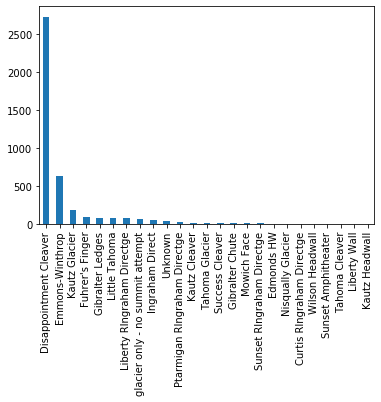

In [7]:
climbs_df.loc[climbs_df.Route == 'Fuhrers Finger', 'Route'] = "Fuhrer's Finger"
print(climbs_df.Route.value_counts())
climbs_df.Route.value_counts().plot.bar()

# Q1: When is peak season for climbing? 

Here I use the full climbing dataset since we do not care about the weather to answer this question

In [8]:
# Calculate number of attempts per day
peak_season = climbs_df[['Date', 'Attempted']]
peak_season = peak_season.groupby('Date').sum()

# create month and weekday dicts to display result in nicer format
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
          7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
weekdays = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Create variables for month and weekday and calculate the number of attemps
peak_season['Month'] = peak_season.index.month
peak_season['Weekday'] = peak_season.index.weekday
peak_season = peak_season.groupby(['Month', 'Weekday']).sum().reset_index()

Weekday    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Month                                                                    
January      18.0      0.0        2.0      21.0    21.0      36.0     8.0
February     16.0      0.0        3.0       0.0    15.0      31.0    19.0
March        54.0      4.0        6.0      11.0    12.0      29.0    41.0
April        59.0      5.0       13.0      19.0    37.0      76.0    64.0
May         264.0    126.0      193.0     192.0   435.0     684.0   234.0
June        820.0    624.0      501.0     700.0   986.0    1159.0   816.0
July        838.0    789.0      673.0    1060.0  1358.0     936.0   825.0
August      629.0    508.0      430.0     433.0   757.0     873.0   680.0
September   280.0    158.0      181.0     152.0   345.0     375.0   277.0
October       1.0      8.0        0.0       2.0     6.0      15.0     0.0
November      0.0      0.0        0.0       0.0     2.0       3.0     2.0
December      0.0      0.0        0.0 

Text(0.5, 1, 'Number of attempts')

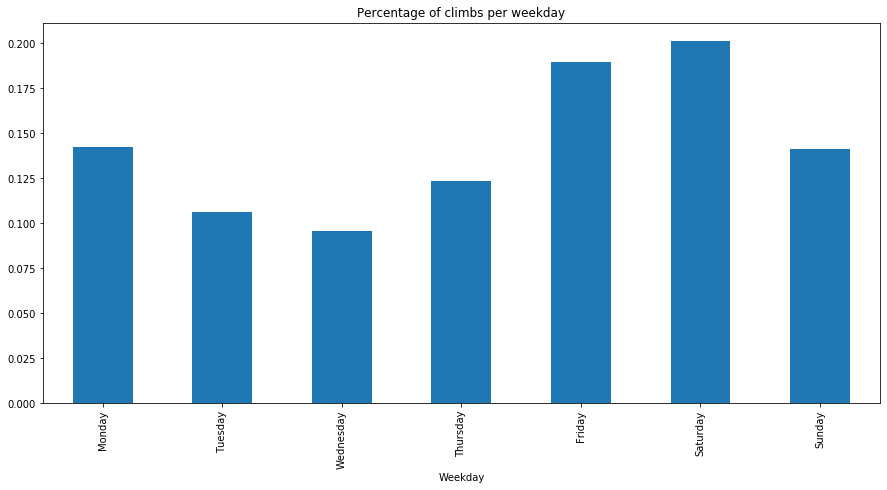

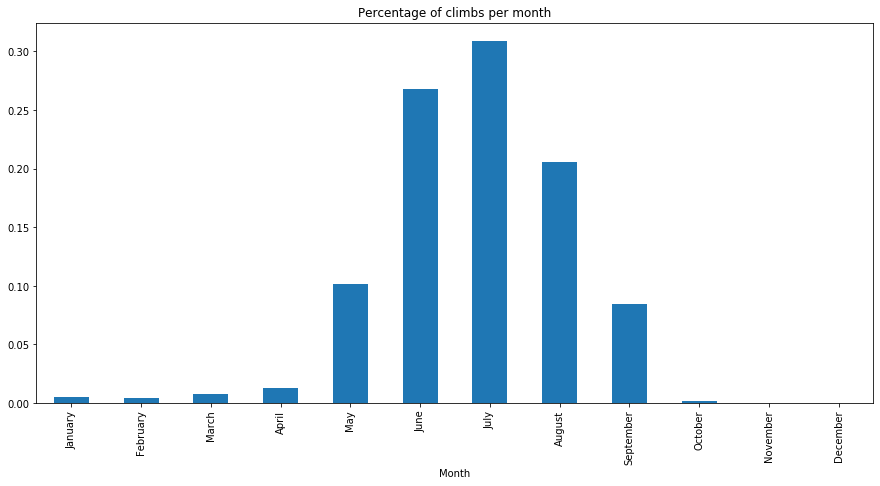

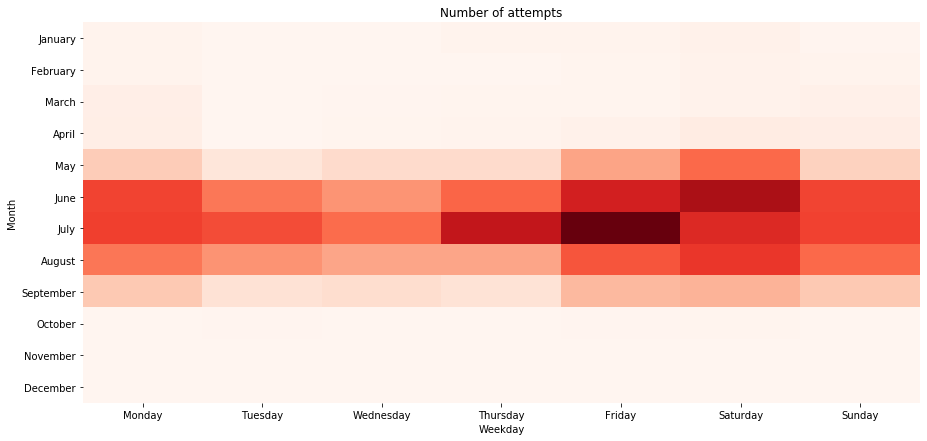

In [9]:
# Prepare data for output
attempts = peak_season.pivot(columns='Weekday', index='Month', values='Attempted').fillna(0)
attempts = attempts.rename(index=months, columns=weekdays)

# Plot the percentage of all attempts per weekday
weekday_prop = attempts.sum() / attempts.sum().sum()
plt.figure()
weekday_prop.plot.bar(figsize=(15,7), title='Percentage of climbs per weekday')

# Print the percentage of all attempts per month
month_prop = attempts.sum(axis=1) / attempts.sum().sum()
plt.figure()
month_prop.plot.bar(figsize=(15,7), title='Percentage of climbs per month')

# Print the number of attempts per month and weekday
print(attempts, '\n\n')

# Create a heatmap of number of attempts
plt.figure(figsize=[15,7])
sns.heatmap(attempts, cmap='Reds', cbar=False)
plt.title('Number of attempts')

It's clear from the picture that peak season is during summer. Popular days for climbing are fridays and saturdays while Wednesdays are less popular.

# Q2: Do popular routes have higher success rate?

Here we only want to look at summit attempts and routes with a number of observations > 20 (in order to reduce randomness in observations). Since we do not care about the weather we can use the full dataset again to answer the question.

In [10]:
# Remove routes with no summit attempt
route_success = climbs_df[climbs_df.Route != 'glacier only - no summit attempt']

# Remove route Unknown
route_success = route_success[route_success.Route != 'Unknown']

# Remove all routes with less than 20 records
routes_to_include = route_success.Route.value_counts() > 20
routes_to_include = routes_to_include[routes_to_include].index.values
route_success = route_success[route_success.Route.isin(routes_to_include)]
route_success.Route.value_counts()

Disappointment Cleaver          2728
Emmons-Winthrop                  632
Kautz Glacier                    182
Fuhrer's Finger                   92
Gibralter Ledges                  76
Little Tahoma                     70
Liberty RIngraham Directge        69
Ingraham Direct                   53
Ptarmigan RIngraham Directge      22
Name: Route, dtype: int64

### Summarise attempts and succeeded per route

Text(0.5, 1.0, 'Success Rate vs Number of Attempts')

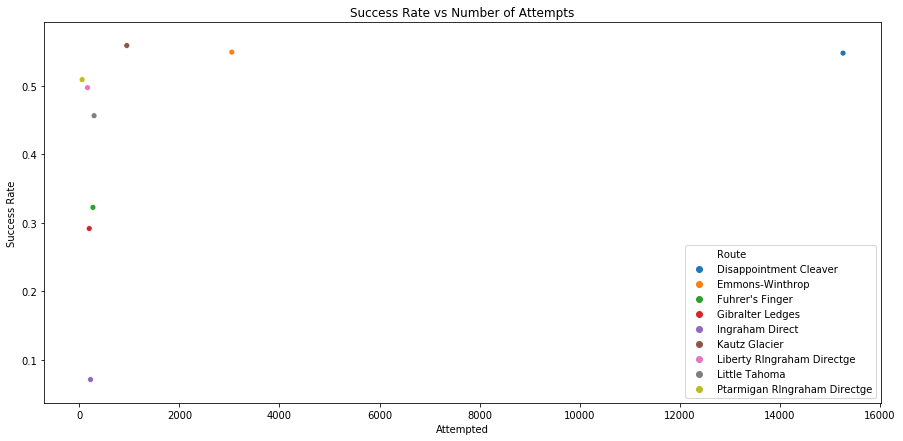

In [11]:
route_success_results = route_success[['Route', 'Attempted', 'Succeeded']].groupby('Route').sum().reset_index()
route_success_results['Success Rate'] = route_success_results['Succeeded'] / route_success_results['Attempted']

plt.figure(figsize=[15,7])
sns.scatterplot(x="Attempted", y="Success Rate", hue="Route", data=route_success_results)
plt.title('Success Rate vs Number of Attempts')

The three most popular routes have the highest success rates. Success rates for the other routes are spread out widely. We can guess that the popular routes are popular because of their higher success rate.

# Q3: What is a good day to go for the top along the most popular route? 

Here we will answer this question by building a model for prediction of success rate. To answer this question we also want to consider weather data since bad weather conditions most likely has a negative impact on success rate. But there are some data we can exclude, such as Battery Voltage for the weather station and number Succeded since we will focus on success rate in this case. We will also drop the Date column since season is expected to be reflected in the weather data. The Attempted column will also be kept since we can consider it as a traffic density on the path and possibly that group size matters. We will only keep the data for Route "Disappointment Cleaver" which is the most popular.

### Prepare the data

Remove columns not needed and then all observations with missing weather data since it's random and hard to impute (remember that it was only weather data with missing values).

In [12]:
model_data = climbs_df[climbs_df.Route == 'Disappointment Cleaver'].copy()
model_data = model_data.drop(['Date', 'Succeeded', 'Battery Voltage AVG', 'Route'], axis=1)
model_data = model_data.dropna()
model_data.head()

,Attempted,Success Percentage,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,2,0.0,26.321667,19.715000,27.839583,68.004167,88.496250
1,3,0.0,31.300000,21.690708,2.245833,117.549667,93.660417
2,2,0.0,46.447917,27.211250,17.163625,259.121375,138.387000
4,2,0.0,38.260417,74.329167,65.138333,264.687500,27.791292
5,10,0.0,31.822917,62.337083,13.125042,153.931667,196.375208


#### Wind direction

Wind direction is a tricky variable since it's measured in 0-359 degrees which means that 0 and 359 is almost the same but very far from each other. To overcome this it's transformed into a categorical direction corresponding to the dircetion (North, East, South, West).

In [13]:
def dir_to_categorical(wind_direction, wind_speed):
    '''
    INPUT
    wind_direction - wind direction in degrees
    wind_speed - wind speed
    
    OUTPUT
    categorical_direction - wind direction in text 
    
    Transform wind direction in degrees to a categorical direction, Nort, East, South, West. If wind speed is below 3 the direction is ignored = "No Wind"
    '''
    if wind_speed < 2:
        return 'No Wind'
    if wind_direction < 45 or wind_direction >= 315:
        return 'North'
    elif wind_direction >= 45 and wind_direction < 135:
        return 'East'
    elif wind_direction >= 135 and wind_direction < 225:
        return 'South'
    elif wind_direction >= 225 and wind_direction < 315:
        return 'West'
    else:
        return 'Error'

model_data['wind_direction_cat'] = model_data.apply(lambda row : dir_to_categorical(row['Wind Direction AVG'], row['Wind Speed Daily AVG']), axis=1)
model_data = model_data.drop(['Wind Direction AVG'], axis=1)
model_data.head()

,Attempted,Success Percentage,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Solare Radiation AVG,wind_direction_cat
0,2,0.0,26.321667,19.715000,27.839583,88.496250,East
1,3,0.0,31.300000,21.690708,2.245833,93.660417,East
2,2,0.0,46.447917,27.211250,17.163625,138.387000,West
4,2,0.0,38.260417,74.329167,65.138333,27.791292,West
5,10,0.0,31.822917,62.337083,13.125042,196.375208,South


#### Handle categorical variables

Create dummies for categorical variables (wind_direction_cat).

In [14]:
# Create dummies for categorical variables
model_data = pd.get_dummies(model_data, columns=['wind_direction_cat'], )
model_data.head()

,Attempted,Success Percentage,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Solare Radiation AVG,wind_direction_cat_East,wind_direction_cat_No Wind,wind_direction_cat_North,wind_direction_cat_South,wind_direction_cat_West
0,2,0.0,26.321667,19.715000,27.839583,88.496250,1,0,0,0,0
1,3,0.0,31.300000,21.690708,2.245833,93.660417,1,0,0,0,0
2,2,0.0,46.447917,27.211250,17.163625,138.387000,0,0,0,0,1
4,2,0.0,38.260417,74.329167,65.138333,27.791292,0,0,0,0,1
5,10,0.0,31.822917,62.337083,13.125042,196.375208,0,0,0,1,0


### Build a linear regression model

In order to answer the question a linear regression model will be built in order to be able to analyse which factors that affects the success rate. Input will be normalized so we can compare coefficients directly. Dataset will be divided into train and test data where validation is done one test set in order to avoid overfitting.

In [15]:
linR = LinearRegression(normalize=True)

X = model_data.loc[:, ['Attempted', 'Temperature AVG', 'Relative Humidity AVG', 'Wind Speed Daily AVG', 'Solare Radiation AVG',
                       'wind_direction_cat_No Wind', 'wind_direction_cat_East', 'wind_direction_cat_North', 'wind_direction_cat_South', 'wind_direction_cat_West']]
y = model_data.loc[:, 'Success Percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

linR.fit(X_train, y_train)
print('Train r2', r2_score(y_train, linR.predict(X_train)))
print('Test r2', r2_score(y_test, linR.predict(X_test)))

Train r2 0.03721209146247573
Test r2 0.03747681332498709


The r2 score is consistent between the train and test sets but at a very low level.

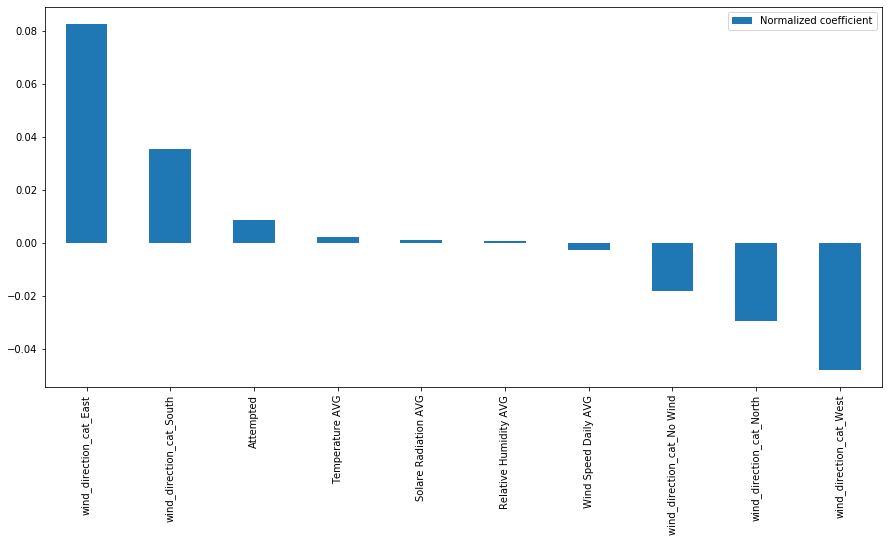

In [16]:
pd.DataFrame(linR.coef_, index=X_train.columns, columns=['Normalized coefficient']).sort_values(by='Normalized coefficient', ascending=False).plot.bar(figsize=(15,7))

 It's hard to predict success rate using only weather data even if it is possible to see some trends like wind from south or west is better than from north or east.